In [175]:
import pandas as pd
import ternary
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
sns.set_context('talk')

from borfr import BO_RFR, fps
import warnings
import os
warnings.filterwarnings("ignore")
from synth_data.plotting_helpers_mixture_frederic import plot_mixture_4d

ldir = [i for i in sorted(os.listdir('mat_dat')) if 'data_' in i]
a = widgets.Dropdown(
    options=ldir,
    value=ldir[0],
    description='Data Set:',
    disabled=False,
)
a

Dropdown(description='Data Set:', options=('data_Ag_Bi_Er_Mn.csv', 'data_Ag_Bi_Mn_Sm.csv', 'data_Al_Bi_Mn_Pb.c…

In [218]:

df = pd.read_csv('mat_dat/%s'%a.value)
els = df.columns[2:6]
df.columns
els


df.values.shape
del_inds = np.where(df['Gap'].values < 1)
vals = np.delete(df.values, del_inds, axis=0)
df = pd.DataFrame(vals, columns=df.columns)
df.values.shape

els

Index(['Bi', 'Ca', 'Ni', 'Sm'], dtype='object')

In [219]:
X_train,X_test = train_test_split(df[['hue','saturation','value']].values, train_size=50, random_state=42)

from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

bgm = BayesianGaussianMixture(n_components=5).fit(X_train)
gap_labels = bgm.predict(df[['hue','saturation','value']].values)

#km = KMeans(n_clusters=3).fit(df[['hue','saturation','value']].values)
#gap_labels = km.labels_

In [220]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

#gap_labels = np.zeros(df['Gap'].values.shape)
#gap_labels[df['Gap'].values < 1.7] = 1.0
#gap_labels[df['Gap'].values > 2.8] = 2.0

np.random.seed(42)
X_train,X_test,y_train,y_test = train_test_split(df[['hue','saturation','value']].values, gap_labels, train_size=50, random_state=42)
rfc = RandomForestClassifier().fit(X_train,y_train)
pred = rfc.predict(X_test)
try:
    print(precision_score(y_test,pred), recall_score(y_test,pred), f1_score(y_test,pred))
except:
    print(precision_score(y_test,pred, average='micro'), recall_score(y_test,pred, average='micro'), f1_score(y_test,pred, average='micro'))


0.9424027509133892 0.9424027509133892 0.9424027509133892


In [221]:
np.unique(gap_labels)

array([0, 1, 2, 4])

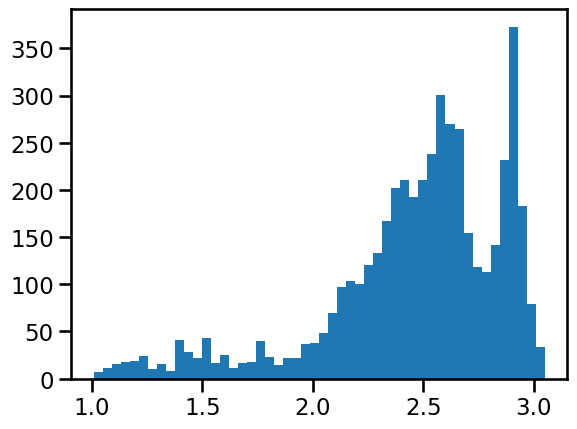

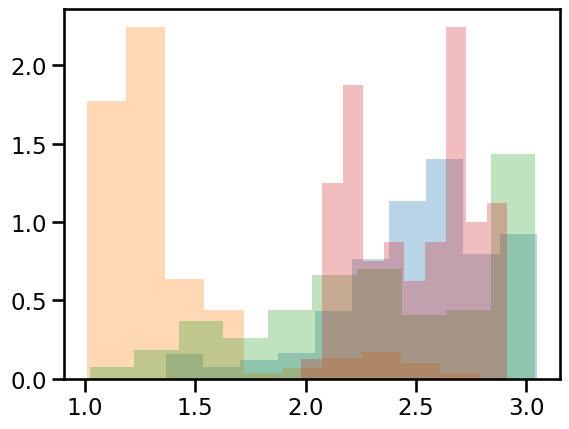

In [222]:
fig,ax = plt.subplots()
ax.hist(df['Gap'].values, bins=50)


grid = df[els].values
vals = df['Gap'].values

from sklearn.mixture import BayesianGaussianMixture

#bgm = BayesianGaussianMixture(n_components=5).fit(vals.reshape(-1,1))
#labels = bgm.predict(vals.reshape(-1,1))

labels = rfc.predict(df[['hue','saturation','value']].values)
fig,ax = plt.subplots()
for i in np.unique(labels):
    ax.hist(vals[labels==i], density=True,alpha=0.3)
#from sklearn.manifold import TSNE
#tsne = TSNE().fit_transform(grid)


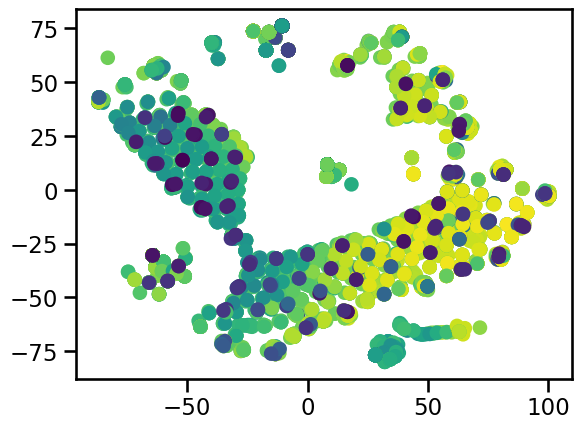

In [223]:
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(df[els].values)

fig,ax = plt.subplots()
ax.scatter(*tsne.T, c=df['Gap'].values)

In [224]:
from borfr import get_N_modes
from sklearn.cluster import AgglomerativeClustering as AC
def f(x):
    ind = np.argmin(np.linalg.norm(grid-x, axis=1))
    return df['Gap'].values[ind]

def get_label(x):
    ind = np.argmin(np.linalg.norm(grid-x, axis=1))
    hsv = df[['hue','saturation','value']].values[ind]
    return rfc.predict([hsv])


grid = df[els].values
vals = df['Gap'].values


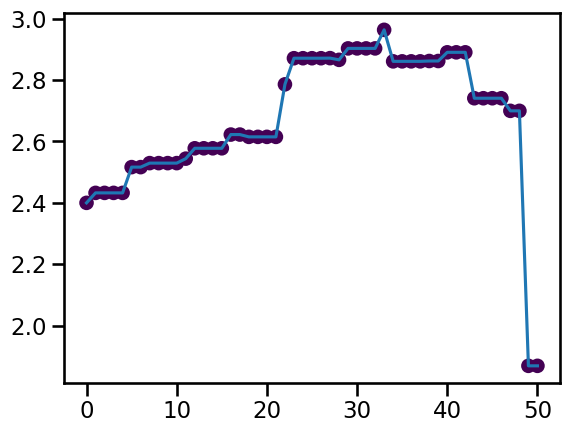

In [225]:
from dexpy.cox_effects import generate_cox_points

i = 0

refp = np.ones(4)*1./3
refp[i] = 0
vec = generate_cox_points(refp, i, 50)

fig,ax = plt.subplots()
ax.plot([f(vi) for vi in vec])
ax.scatter(range(51),[f(vi) for vi in vec],c=[get_label(vi) for vi in vec])

In [226]:
vec.shape

(51, 4)

In [237]:
np.random.seed(10)

X_init = fps(grid,40)
#X_init = grid[np.random.randint(0,171,4)]
y_init = np.array([f(xi) for xi in X_init])

x_test = grid

regm = 'RFC'
clm = 'RFC'

esl = 'known'

n_iter = 100
nb = 5
n_iter_b = int(n_iter/nb)

bor = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=.3, 
             est_labels=esl, N_batch=nb, 
             class_method = clm, reg_method = regm, k_adaptive=True)

bor.run(n_iter_b)

rand_scores = []
for i in range(2):
    rand = BO_RFR(X_init, y_init, grid, f, x_test, 
                  acq='random',gl = get_label,  
                  est_labels=esl, N_batch=1,
                  class_method = clm, reg_method = regm)
    
    rand.run(n_iter)
    rand_scores.append(rand.scores)


sf = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm)

sf.run(n_iter)

gp = BO_RFR(X_init, y_init, grid, f, x_test, 
            acq='SF',gl = get_label, 
            est_labels=esl, N_batch=1,
            class_method = clm, reg_method = regm, gpr=True)

gp.run(n_iter)

generating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4703/4703 [00:00<00:00, 9563.19it/s]


running iterative exploration:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


generating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4703/4703 [00:00<00:00, 9700.93it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


generating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4703/4703 [00:00<00:00, 9436.36it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


generating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4703/4703 [00:00<00:00, 9839.14it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


generating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4703/4703 [00:00<00:00, 9314.35it/s]


running iterative exploration:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


In [246]:
n_iter = 100
nb = 4


regm = 'RFC'
clm = 'RFC'
n_iter_b = int(n_iter/nb)

bor = BO_RFR(X_init, y_init, grid, f, x_test, 
             acq='BO',gl = get_label, cl_weight=.3, 
             est_labels='known', N_batch=nb, 
             class_method = clm, reg_method = regm, k_adaptive=True)

bor.run(n_iter_b)

generating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4703/4703 [00:00<00:00, 9337.06it/s]


running iterative exploration:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.23it/s]


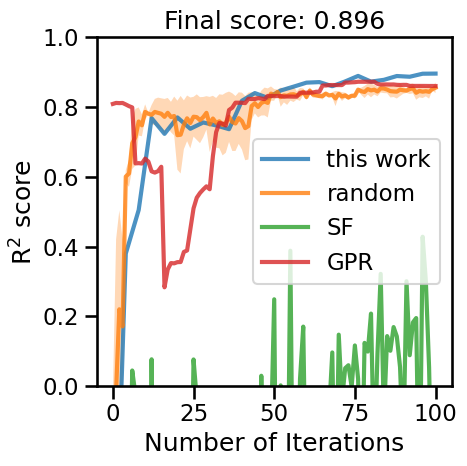

In [247]:
fig, ax2 = plt.subplots(figsize=(5,5))
ax2.plot(np.arange(bor.n_iters+1)*nb,bor.scores,lw=3,alpha=0.8, label='this work')


#ax2.plot(np.arange(rand.n_iters+1),rand.scores,lw=3,alpha=0.8, label='random')
ax2.plot(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0),lw=3,alpha=0.8, label='random')
ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
                 np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')



ax2.plot(np.arange(sf.n_iters+1),sf.scores,lw=3,alpha=0.8, label='SF')

ax2.plot(np.arange(gp.n_iters+1),gp.scores,lw=3,alpha=0.8, label='GPR')


ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$^2$ score')
ax2.set_ylim(0,1)
ax2.legend()
plt.tight_layout()

In [97]:
nb

2

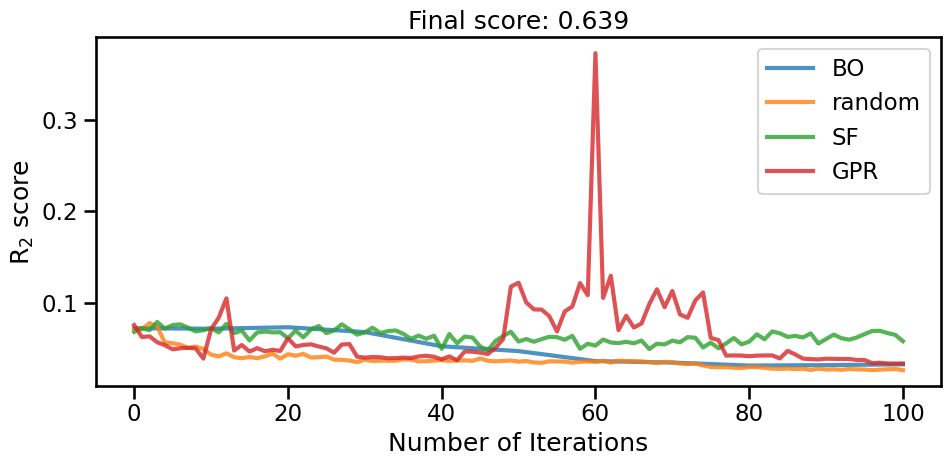

In [38]:
fig, ax2 = plt.subplots(ncols=1, figsize=(10,5))

si = 2

ax2.plot(np.arange(bor.n_iters+1)*nb,np.array(bor.all_scores)[:,si],lw=3,alpha=0.8, label='BO')
try:
    ax2.plot(np.arange(rand.n_iters+1),np.array(rand.all_scores)[:,si],lw=3,alpha=0.8, label='random')
    #ax2.fill_between(np.arange(rand.n_iters+1),np.mean(rand_scores,axis=0)-np.std(rand_scores,axis=0),
    #                 np.mean(rand_scores,axis=0)+np.std(rand_scores,axis=0), alpha=0.3, fc='C1')
except:
    pass

try:
    ax2.plot(np.arange(sf.n_iters+1),np.array(sf.all_scores)[:,si],lw=3,alpha=0.8, label='SF')
except:
    pass

try:
    ax2.plot(np.arange(gp.n_iters+1),np.array(gp.all_scores)[:,si],lw=3,alpha=0.8, label='GPR')
except:
    pass
ax2.set_title('Final score: %.3f'%bor.scores[-1])
ax2.set_xlabel('Number of Iterations')
ax2.set_ylabel('R$_2$ score')
#ax2.set_ylim(0,1)
ax2.legend()
plt.tight_layout()

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

gap_labels = np.zeros(df['Gap'].values.shape)
gap_labels[df['Gap'].values > 2.8] = 1.0
#gap_labels[df['Gap'].values > 2.8] = 2.0

lda = RandomForestClassifier().fit(df[els].values,gap_labels)
pred = lda.predict(df[els].values)
f1_score(pred,gap_labels)

0.003430531732418525